In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
import os
import sys
print("at directory:", os.getcwd())
print("changing to root directory")
os.chdir("../..")
print("at directory:", os.getcwd())

at directory: /Users/wilka/git/research/jaxneurorl/projects/humansf
changing to root directory
at directory: /Users/wilka/git/research/jaxneurorl


In [3]:
import jax
import jax.numpy as jnp
import json
import functools

from xminigrid.rendering.rgb_render import render
import numpy as np
from IPython.display import Image

from library import parallel

from singleagent import value_based_basics as vbb

from projects.humansf import visualizer
from projects.humansf import keyroom
from projects.humansf import minigrid_common

In [4]:
# Open the file and load the JSON data
with open("projects/humansf/maze_pairs.json", "r") as file:
    maze_config = json.load(file)[0]

In [5]:
from pprint import pprint


pprint(maze_config)

env = keyroom.KeyRoom()
env_params = env.default_params(
    maze_config=keyroom.shorten_maze_config(maze_config, 1)
)
env_params

{'keys': [['key', 'grey'],
          ['key', 'red'],
          ['key', 'purple'],
          ['key', 'yellow']],
 'pairs': [[['box', 'blue'], ['ball', 'blue']],
           [['box', 'purple'], ['box', 'green']],
           [['ball', 'green'], ['box', 'yellow']],
           [['key', 'blue'], ['key', 'green']]]}


KeyRoomEnvParams(height=19, width=19, view_size=7, render_mode='rgb_array', random_door_loc=False, train_single=True, training=True, maze_config={'keys': Array([[9, 8]], dtype=uint8), 'pairs': Array([[[6, 5],
        [5, 5]]], dtype=uint8)}, task_objects=Array([[[ 9,  8,  1,  1],
        [12,  8,  1,  0],
        [ 6,  5,  1,  1],
        [ 5,  5,  1,  1]]], dtype=uint8), train_w=Array([[0.1 , 0.25, 1.  , 0.  ]], dtype=float32), test_w=Array([[0., 0., 0., 1.]], dtype=float32))

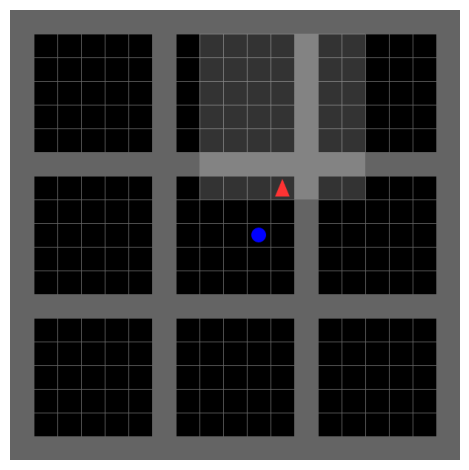

In [13]:
seed=0
rng = jax.random.PRNGKey(seed)
rng, rng_ = jax.random.split(rng)
for seed in range(0, 1):
    rng, rng_ = jax.random.split(rng)
    timestep = env.reset(rng_, env_params)
    
    # get image of full state
    state_image = env.render(env_params, timestep)
    visualizer.display_image(state_image)
    
    # # get image of what agent observes (theirs is symbolic)
    # obs_image = keyroom.render_room(timestep.state)
    # visualizer.display_image(obs_image)
    
    # jax.tree_map(lambda x:x.shape, timestep.observation)

In [15]:
timestep.state.agent.position, timestep.state.local_agent_position

(Array([ 7, 11], dtype=int32), Array([1, 5], dtype=int32))

In [16]:
timestep.observation.image[1, 5]

Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.],      dtype=float32)

In [18]:
timestep.observation.image[3, 3], timestep.observation.image[3, 4]

(Array([0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32),
 Array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],      dtype=float32))

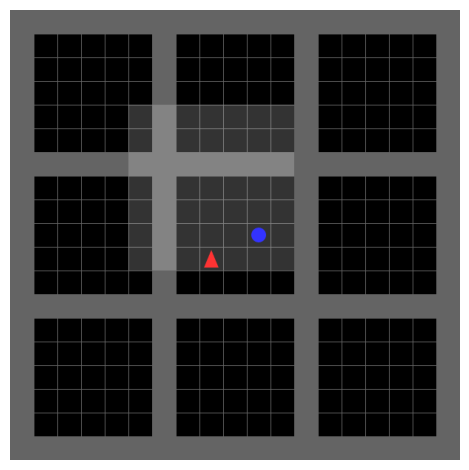

63 1.0


In [12]:
# rng = jax.random.PRNGKey(1)  # multiroom
rng = jax.random.PRNGKey(3)  # single room
rng, rng_ = jax.random.split(rng)
env_params = env_params.replace(training=True)
timestep = env.reset(rng_, env_params)
state_image = env.render(env_params, timestep)
visualizer.display_image(state_image)
t_limit = 150

# state_seq = [env.render(env_params, timestep)]
obs_seq = [keyroom.render_room(timestep.state)]
reward_seq = [timestep.reward]

t_counter = 0
while True:
    rng, rng_act, rng_step = jax.random.split(rng, 3)
    action = jax.random.randint(rng_act, (), 0, env.num_actions(env_params))

    timestep = env.step(rng_step, timestep, action, env_params)
    # state_seq.append(env.render(env_params, timestep))
    obs_seq.append(keyroom.render_room(timestep.state))
    reward_seq.append(timestep.reward)

    # obs_image = keyroom.render_room(timestep)
    # visualizer.display_image(obs_image)

    t_counter += 1
    if timestep.last() or t_counter >= t_limit:
        break

cum_rewards = jnp.cumsum(jnp.array(reward_seq))
print(t_counter, sum(reward_seq))

MovieWriter ffmpeg unavailable; using Pillow instead.


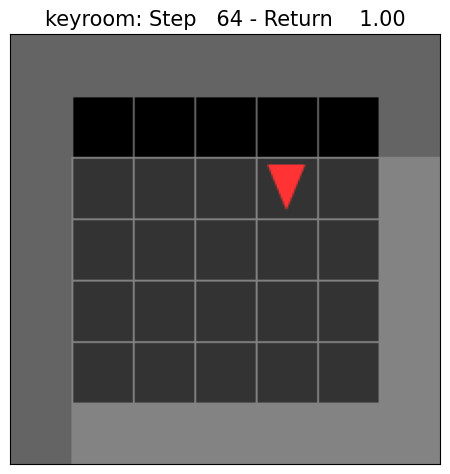

In [19]:
vis = visualizer.Visualizer(env, env_params, obs_seq, cum_rewards)
vis.animate(f"analysis_media/anim1.gif")
Image(url=f"analysis_media/anim1.gif")  